<a href="https://colab.research.google.com/github/Aiden-Ross-Dsouza/Generative-Models/blob/main/Generative%20Adversarial%20Networks/notebooks/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [1]:
pip install pytorch-fid

# Import Liraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

# Critic

In [3]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            # Input: N X channels_img X 64 X 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1), # 32 X 32
            nn.LeakyReLU(0.2),
            self.block(features_d, features_d*2, 4, 2, 1), # 16 X 16
            self.block(features_d*2, features_d*4, 4, 2, 1), # 8 X 8
            self.block(features_d*4, features_d*8, 4, 2, 1), # 4 X 4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1 X 1
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                             nn.BatchNorm2d(out_channels),
                             nn.LeakyReLU(0.2))

    def forward(self, x):
        return self.critic(x)

# Generator

In [4]:
class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        # Input: N X z_dim X 1 X 1
        self.block(z_dim, features_g*16, 4, 1, 0), #N X f_g*16 X 4 X 4
        self.block(features_g*16, features_g*8, 4, 2, 1), # 8 X 8
        self.block(features_g*8, features_g*4, 4, 2, 1), # 16 X 16
        self.block(features_g*4, features_g*2, 4, 2, 1), # 32 X 32
        nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), # 64 X 64
        nn.Tanh(),
    )

  def block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.gen(x)

# Initialize weights

In [5]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

# Test

In [6]:
def test():
  N, in_channels, H, W = 8, 3, 64, 64
  z_dim = 100
  x = torch.randn((N, in_channels, H, W))
  critic = Critic(in_channels, 8)
  initialize_weights(critic)
  assert critic(x).shape == (N, 1, 1, 1)
  gen = Generator(z_dim, in_channels, 8)
  initialize_weights(gen)
  z = torch.randn((N, z_dim, 1, 1))
  assert gen(z).shape == (N, in_channels, H, W)
  print("Success")

# Visualize Generated Images

In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2  # De-normalize the images to [0, 1] range
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Save Images

In [8]:
os.makedirs('generated_images', exist_ok=True)
os.makedirs('real_images', exist_ok=True)

def save_images(images, directory, prefix, num_images=25):
    images = (images + 1) / 2  # De-normalize the images to [0, 1] range
    image_grid = torchvision.utils.make_grid(images[:num_images], nrow=5)
    image_grid = image_grid.permute(1, 2, 0).cpu().numpy() * 255
    image_filename = os.path.join(directory, f"{prefix}.png")
    plt.imsave(image_filename, image_grid.astype(np.uint8))

# Train

100%|██████████| 170498071/170498071 [00:05<00:00, 28546765.53it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset/
Epoch [0/5] Batch 0/782           Loss D: -0.0465, loss G: 0.0249


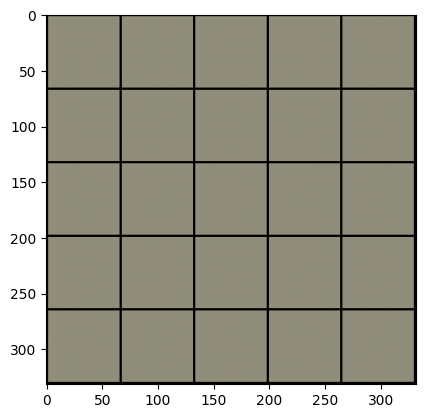

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 5e-5
batch_size = 64
image_size = 64
channels_img = 3
z_dim = 100
num_epochs = 5
features_critic = 64
features_gen = 64
critic_iterations = 5
weight_clip = 0.01

image_transforms = transforms.Compose(
    [
     transforms.Resize(image_size),
     transforms.ToTensor(),
     transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
    ]
)

dataset = datasets.CIFAR10(root = "dataset/", train=True, transform=image_transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
gen = Generator(z_dim, channels_img, features_gen).to(device)
critic = Critic(channels_img, features_critic).to(device)
initialize_weights(gen)
initialize_weights(critic)

opt_gen = optim.RMSprop(gen.parameters(), lr=lr)
opt_critic = optim.RMSprop(critic.parameters(), lr=lr)

fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

gen_losses = []
critic_losses = []
iterations = []

for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.to(device)

    # Train critic
    for _ in range(critic_iterations):
      noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
      fake = gen(noise)
      critic_real = critic(real).reshape(-1)
      critic_fake = critic(fake).reshape(-1)
      loss_critic = - (torch.mean(critic_real) - torch.mean(critic_fake))
      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      opt_critic.step()

      for p in critic.parameters():
        p.data.clamp_(-weight_clip, weight_clip)

    # Train Generator: min -E[critic(gen_fake)]
    output = critic(fake).reshape(-1)
    loss_gen = -torch.mean(output)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    #Print losses occassionally
    if batch_idx % 100 == 0:
      print(
          f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
          Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
      )

      with torch.no_grad():
        fake = gen(fixed_noise)
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=step)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        save_images(real.cpu(), 'real_images', f'real_epoch_{epoch}_batch_{batch_idx}')
        save_images(fake.cpu(), 'generated_images', f'fake_epoch_{epoch}_batch_{batch_idx}')

        show_tensor_images(fake, num_images=25, size=(channels_img, image_size, image_size))

      step += 1

# Calculate Frechet Inception Distance

In [ ]:
def compute_fid(real_images_dir, fake_images_dir):
    # Call the FID computation from the command line
    result = subprocess.run([
        'python', '-m', 'pytorch_fid', real_images_dir, fake_images_dir
    ], capture_output=True, text=True)

    # Parse and print FID score
    fid_score_line = [line for line in result.stdout.split('\n') if 'FID' in line]
    if fid_score_line:
        fid_score = fid_score_line[0].split()[-1]
        print(f"FID Score: {fid_score}")

# Call this function after training
compute_fid('real_images', 'generated_images')


# Plot Losses

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(iterations, gen_losses, label='Generator Loss')
plt.plot(iterations, critic_losses, label='Critic Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator and Critic Losses')
plt.legend()
plt.show()